In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
path = '/content/drive/Shareddrives/창종설2(김동준노현손영은윤우현최민호)/bike_dataset_edit_ver3.csv'
df = pd.read_csv(path)
print(df.head())
df.pop('날짜')
a = df.to_numpy()
a.shape

           날짜  평균기온  송파구 따릉이 검색량  코로나 확진자수  송파구 따릉이 이용건수  강수량
0  2017-08-01  28.4     14.70588         0           502  2.0
1  2017-08-02  30.0      0.00000         0           481  0.0
2  2017-08-03  30.1     64.70588         0           470  0.0
3  2017-08-04  30.3     50.00000         0           474  0.0
4  2017-08-05  31.4     23.52941         0           459  0.0


(1428, 5)

In [3]:
data = []
target = []

seq_len = 365
pred_len = 20

for i in range(len(a)-(seq_len+pred_len-1)):
    data.append(a[i : i + seq_len])
    target.append(a[i + seq_len : i + seq_len + pred_len,-2])

In [4]:
data = np.array(data)
target = np.array(target)
print(data.shape)
print(target.shape)

(1044, 365, 5)
(1044, 20)


In [5]:
train_len = 800
test_len = len(data) - train_len

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((data[:train_len], target[:train_len]))
test_dataset = tf.data.Dataset.from_tensor_slices((data[train_len:], target[train_len:]))

In [7]:
batch_size = 256
train_dataset = train_dataset.shuffle(len(data)).repeat().batch(batch_size)
test_dataset = test_dataset.shuffle(len(data)).repeat().batch(batch_size)

# LSTM Model_ver.1

In [8]:
input_Layer = tf.keras.layers.Input(shape=(seq_len,5,))
x = tf.keras.layers.LSTM(1024, return_sequences=True)(input_Layer)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.LSTM(256) (x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
Out_Layer=tf.keras.layers.Dense(pred_len, activation = None)(x)
model_ver1 = tf.keras.Model(inputs=[input_Layer], outputs=[Out_Layer])
model_ver1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 365, 5)]          0         
                                                                 
 lstm (LSTM)                 (None, 365, 1024)         4218880   
                                                                 
 dropout (Dropout)           (None, 365, 1024)         0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               1311744   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1024)              263168    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096  

In [9]:
decay_steps = 350
cos_decay = tf.keras.experimental.CosineDecay(1e-3,
                                              decay_steps) 
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [10]:
loss_function=tf.keras.losses.mean_squared_error
optimize=tf.keras.optimizers.Adam(learning_rate=0.001)
metric=tf.keras.metrics.mean_absolute_error
model_ver1.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

history = model_ver1.fit(
      train_dataset,
      steps_per_epoch = train_len // batch_size,
      epochs=300,
      validation_data = test_dataset,
      validation_steps = test_len // batch_size,
      callbacks=[lr_callback]
)


Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/300
3/3 [==============================] - 14s 2s/step - loss: 24597552.0000 - mean_absolute_error: 4305.7036 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009999799, shape=(), dtype=float32).
Epoch 2/300
3/3 [==============================] - 6s 2s/step - loss: 24419742.0000 - mean_absolute_error: 4289.0103 - lr: 9.9998e-04

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009999195, shape=(), dtype=float32).
Epoch 3/300
3/3 [==============================] - 6s 2s/step - loss: 24880344.0000 - mean_absolute_error: 4335.2368 - lr: 9.9992e-04

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009998188, shape=(), dtype=float32).
Epoch 4/300
3/3 [==============================] - 6s 2s/step - loss: 24106674.0000 - mean_absolute_error: 4247.2529 - lr: 9.9982e-04

Epoch 00005: LearningRateSche

In [11]:
test_data = data.reshape(-1,seq_len,5)
target_data = target.reshape(-1,1)
pred_data_ver1 = model_ver1.predict(test_data)

ValueError: ignored

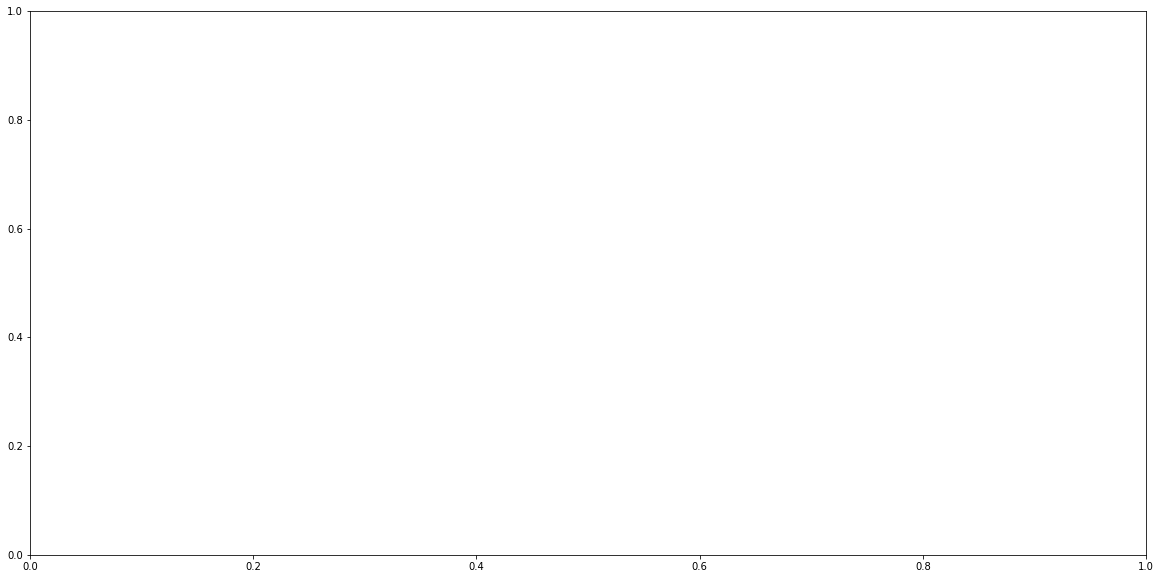

In [12]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, seq_len + train_len + test_len), a[:,-2])
plt.plot(np.arange(seq_len, seq_len + train_len + test_len), pred_data_ver1.flatten())
plt.show()

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(target, pred_data_ver1)
mae = mean_absolute_error(target, pred_data_ver1)
rmse = mse ** 0.5

print('mse: ', mse)
print('rmse: ', rmse)
print('mae: ', mae)

def mape(inp1, inp2):
    result = 0
    for i in range(len(inp1)):
        result += abs((inp1[i] - inp2[i]) / inp1[i])
    result = result * 100 / len(inp1)
    return result

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('mape: ', mape(target, pred_data_ver1))
print('MAPE: ', MAPE(target, pred_data_ver1))

# LSTM Model_ver.2

In [13]:
input_Layer = tf.keras.layers.Input(shape=(seq_len,5,))
x = tf.keras.layers.LSTM(256, return_sequences=True)(input_Layer)
x = tf.keras.layers.LSTM(256, return_sequences=True)(x)
x = tf.keras.layers.LSTM(256) (x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(1024)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)
Out_Layer=tf.keras.layers.Dense(pred_len, activation = None)(x)
model_ver2 = tf.keras.Model(inputs=[input_Layer], outputs=[Out_Layer])
model_ver2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 365, 5)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 365, 256)          268288    
                                                                 
 lstm_3 (LSTM)               (None, 365, 256)          525312    
                                                                 
 lstm_4 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              263168    
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096

In [14]:
decay_steps = 350
cos_decay = tf.keras.experimental.CosineDecay(1e-3,
                                              decay_steps) 
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [15]:
loss_function=tf.keras.losses.mean_squared_error
optimize=tf.keras.optimizers.Adam(learning_rate=0.001)
metric=tf.keras.metrics.mean_absolute_error
model_ver2.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

history = model_ver2.fit(
      train_dataset,
      steps_per_epoch = train_len // batch_size,
      epochs=300,
      validation_data = test_dataset,
      validation_steps = test_len // batch_size,
      callbacks=[lr_callback]
)


Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/300
3/3 [==============================] - 8s 711ms/step - loss: 24662088.0000 - mean_absolute_error: 4317.0942 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009999799, shape=(), dtype=float32).
Epoch 2/300
3/3 [==============================] - 2s 716ms/step - loss: 24539578.0000 - mean_absolute_error: 4294.3052 - lr: 9.9998e-04

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009999195, shape=(), dtype=float32).
Epoch 3/300
3/3 [==============================] - 2s 713ms/step - loss: 24351206.0000 - mean_absolute_error: 4278.8379 - lr: 9.9992e-04

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009998188, shape=(), dtype=float32).
Epoch 4/300
3/3 [==============================] - 2s 710ms/step - loss: 24870000.0000 - mean_absolute_error: 4338.7446 - lr: 9.9982e-04

Epoch 00005: Learn

In [ ]:
test_data = data.reshape(-1,seq_len,5)
target_data = target.reshape(-1,1)
pred_data_ver2 = model_ver2.predict(test_data)

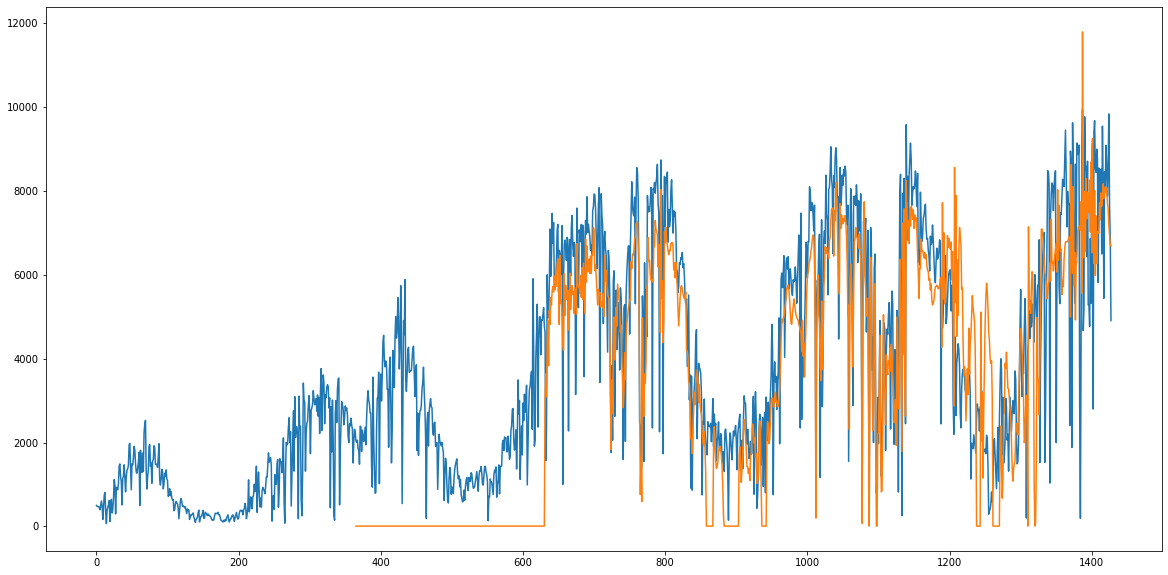

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0, seq_len + train_len + test_len), a[:,-2])
plt.plot(np.arange(seq_len, seq_len + train_len + test_len), pred_data_ver2.flatten())
plt.show()

No handles with labels found to put in legend.


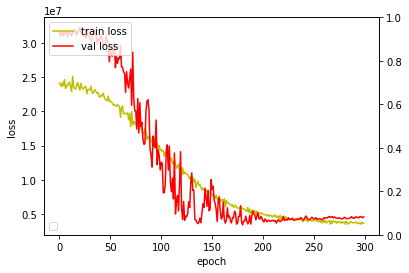

In [ ]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
test_data.shape

(1063, 365, 5)

In [ ]:
a.shape

(1428, 5)

In [ ]:
pred_data_ver2.shape

(1063, 1)

In [ ]:
target.shape

(1063, 1)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(target, pred_data_ver2)
mae = mean_absolute_error(target, pred_data_ver2)
rmse = mse ** 0.5

print('mse: ', mse)
print('rmse: ', rmse)
print('mae: ', mae)

def mape(inp1, inp2):
    result = 0
    for i in range(len(inp1)):
        result += abs((inp1[i] - inp2[i]) / inp1[i])
    result = result * 100 / len(inp1)
    return result

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('mape: ', mape(target, pred_data_ver2))
print('MAPE: ', MAPE(target, pred_data_ver2))

mse:  3752658.0871914392
rmse:  1937.1778666894372
mae:  1548.2054946940684
mape:  [61.5333417]
MAPE:  61.53334169972177
